## Data loading

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import coo_matrix,hstack
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score,accuracy_score

import re
import pickle
from scipy.special import softmax
from nltk.corpus import stopwords

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading the data** (using the path of the real data)

In [ ]:
data_file ="/content/drive/MyDrive/capstone-pimco/Part1/data/"

In [6]:
df_train = pd.read_csv(data_file+"training_data_preprocess.csv", index_col=0)

In [7]:
df_test = pd.read_csv(data_file+"test_preprocess_by_sentence.csv", index_col=0)

# topic modification

Since there are overlaps between topics, we modify the topic labels as below.

### global growth -> growth
### remove monetary policy 
### remove financial conditions

In [8]:
def topic(x):
  topic = x.split('/')
  # replace global growth with growth
  if 'global growth' in topic:
    topic.remove('global growth')
    if 'growth' not in topic:
      topic.append('growth')
  # remove monetary policy
  if 'monetary policy' in topic:
    topic.remove('monetary policy')
  # remove financial conditions
  if 'financial conditions' in topic:
    topic.remove('financial conditions')
  return '/'.join(topic)

In [9]:
df_train['topic'] = df_train['topic'].map(topic)

In [10]:
df_train.head()

,topic,sentence,text
0,credit,bank lending continues to contract,bank lending continues contract
1,credit,tight credit,tight credit
2,credit,Bank lending has continued to contract in rece...,bank lending continued contract recent month
3,credit,Bank lending has continued to contract,bank lending continued contract
4,credit,Bank lending has continued to contract but at ...,bank lending continued contract reduced rate r...


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 389
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   topic     390 non-null    object
 1   sentence  390 non-null    object
 2   text      390 non-null    object
dtypes: object(3)
memory usage: 12.2+ KB


In [ ]:
df_train['topic'].value_counts()

growth                             108
inflation                           55
labor market                        53
quantitative easing                 43
fed funds rate                      41
credit                              28
liquidity measures                  22
housing                             18
financial markets                   13
geopolitical uncertainty             7
geopolitical uncertainty/growth      2
Name: topic, dtype: int64

In [11]:
df_train.insert(0, "sentence_id", range(len(df_train)))

In [12]:
df_train

,sentence_id,topic,sentence,text
0,0,credit,bank lending continues to contract,bank lending continues contract
1,1,credit,tight credit,tight credit
2,2,credit,Bank lending has continued to contract in rece...,bank lending continued contract recent month
3,3,credit,Bank lending has continued to contract,bank lending continued contract
4,4,credit,Bank lending has continued to contract but at ...,bank lending continued contract reduced rate r...
...,...,...,...,...
385,385,credit,the anticipated expiration dates for the term ...,anticipated expiration date term asset backed ...
386,386,credit,march 31 for loans backed by all other types o...,march loan backed type collateral
387,387,credit,"the only remaining such program, the term asse...","remaining program, term asset backed security ..."
388,388,credit,the federal reserve will be implementing the t...,federal reserve implementing term asset backed...


# Benchmark Models

## Data preprocessing(TfidfVectorizer)

Split train and test data and stratify on the topic label. 

In [13]:
df_train = df_train.set_index('sentence_id')
X_train, X_val, y_train, y_val = train_test_split(df_train['text'], df_train['topic'], stratify = df_train['topic'], test_size=0.25, random_state=42)

In [14]:
train_idx = X_train.index
val_idx = X_val.index

For multi-topic sentence, split the topic. For example, if a row has topic geopolitical uncertainty/growth, we make it as two rows with the same text and one belongs to geopolitical uncertainty, the other belongs to growth.

In [15]:
y = pd.DataFrame(df_train['topic']).apply(lambda x: x.str.split('/').explode())
le = LabelEncoder()
labels = np.array(le.fit_transform(y))
label_df = pd.DataFrame(labels, index=y.index)
label_df

,0
sentence_id,
0,0
1,0
2,0
3,0
4,0
...,...
385,0
386,0
387,0


In [17]:
le.classes_

array(['credit', 'fed funds rate', 'financial markets',
       'geopolitical uncertainty', 'growth', 'housing', 'inflation',
       'labor market', 'liquidity measures', 'quantitative easing'],
      dtype=object)

In [16]:
y_train = label_df.loc[train_idx]
y_val = label_df.loc[val_idx]
X_train = df_train.loc[y_train.index, 'text']
X_val = df_train.loc[y_val.index, 'text']

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(294,)
(294, 1)
(98,)
(98, 1)


Transform the text data to tf-idf vectors.

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
min_n = 1
max_n = 2
max_df = 0.8
k = None
stopwords_list = stopwords.words('english')
tfidf_vec = TfidfVectorizer(ngram_range=(min_n,max_n),sublinear_tf=True,max_df=max_df,max_features=k,stop_words=stopwords_list)
tfidf_vec.fit(X_train)

TfidfVectorizer(max_df=0.8, ngram_range=(1, 2),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                sublinear_tf=True)

In [21]:
tfidf_X_train = tfidf_vec.transform(X_train)
tfidf_X_val = tfidf_vec.transform(X_val)

The transformed tf-idf vector's dimension is 2342, which is the vocabulary size of the training data.

In [22]:
print(tfidf_X_train.shape)
print(tfidf_X_val.shape)
print(y_train.shape)
print(y_val.shape)

(294, 2342)
(98, 2342)
(294, 1)
(98, 1)


## Metrics measurement

Define function to calculate the metrics of the classification result.

In [23]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss

ModelsPerformance = {}

def metricsReport(modelName, test_labels, predictions):
    accuracy = accuracy_score(test_labels, predictions)

    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')

    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    hamLoss = hamming_loss(test_labels, predictions)
    print("------" + modelName + " Model Metrics-----")
    print("Accuracy: {:.4f}\nHamming Loss: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
          .format(accuracy, hamLoss, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))
    ModelsPerformance[modelName] = micro_f1

## Random Forest

Use random forest to classify the topic.

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [25]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(tfidf_X_train, y_train)
rfPredictions = rf.predict(tfidf_X_val)
metricsReport("random forest", y_val, rfPredictions)

------random forest Model Metrics-----
Accuracy: 0.8469
Hamming Loss: 0.1531
Precision:
  - Macro: 0.7583
  - Micro: 0.8469
Recall:
  - Macro: 0.7228
  - Micro: 0.8469
F1-measure:
  - Macro: 0.7265
  - Micro: 0.8469


In [ ]:
y_val[0].value_counts()

4    27
6    14
7    13
9    11
1    10
0     7
8     6
5     5
2     3
3     2
Name: 0, dtype: int64

A sentence can have multiple topics, but random forest only assigns one data point to one class. Instead of directly using the predicted result of the random forest, we set up a threshold to determine topic for each row. If the predicted probability of topic A is above the threshold, then we say the sentence is talking about topic A. 

In [26]:
rfPrediction = rf.predict_proba(tfidf_X_val)

In [27]:
def get_predicted_topics(prediction_result,thresh):
  result = []
  for pred in prediction_result:
    label = []
    sum = np.sum(pred)
    for j in range(len(pred)):
      if pred[j] > sum*thresh:
        label.append(le.classes_[j])
    result.append("/".join(label))
  return result

In [28]:
rfPredictions_val = get_predicted_topics(rfPrediction, 0.3)

In [29]:
X_val

sentence_id
35     investment nonresidential structure still weak...
340    committee add holding agency mortgage backed s...
371    federal reserve prepared use full range tool s...
42                     adjustment housing sector ongoing
167    inflation picked recent month however continue...
                             ...                        
57                             international development
125        generate economic weakness foreseeable future
219                      labor market condition improved
250    utilization pool available worker remains unus...
298    related action board governor unanimously appr...
Name: text, Length: 98, dtype: object

In [30]:
df_val = df_train.loc[X_val.index]
df_val['pred'] = rfPredictions_val
df_val = df_val[~df_val.index.duplicated(keep='first')] # deleted repetition
df_val

,topic,sentence,text,pred
sentence_id,,,,
35,housing,investment in nonresidential structures is sti...,investment nonresidential structure still weak...,housing
340,quantitative easing,the Committee will add to its holdings of agen...,committee add holding agency mortgage backed s...,quantitative easing
371,quantitative easing,The Federal Reserve is prepared to use its ful...,federal reserve prepared use full range tool s...,quantitative easing
42,housing,the adjustment in the housing sector is ongoing,adjustment housing sector ongoing,housing
167,inflation,Inflation picked up in recent months however i...,inflation picked recent month however continue...,inflation
...,...,...,...,...
57,growth,and international developments,international development,growth
125,growth,generate economic weakness in the foreseeable...,generate economic weakness foreseeable future,growth
219,labor market,labor market conditions improved further,labor market condition improved,labor market


:Store the predicting result

In [31]:
df_val.to_csv(data_file+'validation_prediction.csv')

Since each data point can belong to multiple topics, we need to define custom accuracy measurements for the model prediction result.

In [32]:
def cust_acc(predict, ground):
    set_pred = [set(x.split("/")) for x in predict]
    set_ground =  [set(x.split("/")) for x in ground]
    n = len(predict)
    recall_score = 0
    prec_score = 0
    acc_score = 0
    for i in range(n):
        target = set_pred[i].intersection(set_ground[i])
        recall_score += len(target) / len(set_ground[i])
        if len(set_pred[i]) == 0:
            continue
        else:
            prec_score += len(target) / len(set_pred[i]) 
        if len(target) == len(set_ground[i]) and len(target) == len(set_pred[i]):
            # only when the predicted topics equal to the true topics, the accuracy is 1, otherwise 0.
            acc_score += 1
    return acc_score/n, prec_score /n, recall_score/n

We try different threshold, from 0.1 to 0.5 and calculate the prediction accuracy, precision and recall. Select the best threshold according to the table below.  

In [33]:
for i in np.arange(0.1,0.5,0.05):
  rfPredictions_val = get_predicted_topics(rfPrediction,i)
  rfPredictions_val_df = pd.DataFrame(rfPredictions_val, index=X_val.index)
  rfPredictions_val_df = rfPredictions_val_df[~rfPredictions_val_df.index.duplicated(keep='first')]
  acc, prec, recall = cust_acc(rfPredictions_val_df[0], df_val['topic'])
  print("Threshhold: {}:\n Accuracy: {}, precision: {}, Recall: {}".format(i,acc, prec, recall))

Threshhold: 0.1:
 Accuracy: 0.4897959183673469, precision: 0.6904761904761907, Recall: 0.9693877551020408
Threshhold: 0.15000000000000002:
 Accuracy: 0.6224489795918368, precision: 0.7636054421768707, Recall: 0.9285714285714286
Threshhold: 0.20000000000000004:
 Accuracy: 0.6530612244897959, precision: 0.7755102040816326, Recall: 0.9081632653061225
Threshhold: 0.25000000000000006:
 Accuracy: 0.7244897959183674, precision: 0.8061224489795918, Recall: 0.8877551020408163
Threshhold: 0.30000000000000004:
 Accuracy: 0.7959183673469388, precision: 0.8367346938775511, Recall: 0.8775510204081632
Threshhold: 0.3500000000000001:
 Accuracy: 0.7959183673469388, precision: 0.826530612244898, Recall: 0.8571428571428571
Threshhold: 0.40000000000000013:
 Accuracy: 0.7857142857142857, precision: 0.8010204081632653, Recall: 0.8163265306122449
Threshhold: 0.45000000000000007:
 Accuracy: 0.7857142857142857, precision: 0.7908163265306123, Recall: 0.7959183673469388


We choose the threshold to be 0.3.

In [34]:
X_test = df_test
tfidf_X_test = tfidf_vec.transform(X_test['text']) # tfidf transformer would deal with stopwords in test data

# Train random forest on whole dataset

In [ ]:
y_whole = label_df.loc[:]
X_whole = df_train.loc[y_whole.index, 'text']
tfidf_X_whole = tfidf_vec.transform(X_whole)
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(tfidf_X_whole, y_whole)

RandomForestClassifier(class_weight='balanced')

Predict on the test set.

In [35]:
rfPredictions_sample_test = rf.predict_proba(tfidf_X_test)

In [37]:
X_test["predicted_topics"] = get_predicted_topics(rfPredictions_sample_test, 0.3)

In [36]:
X_test

,sentence,sentence_order,extracted_date,text_type,aws_file_location,institution,uncleaned_text,text,word_count
0,b'Governor Lael Brainard\n\nAt the Council on ...,0,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,Governor Lael Brainard At the Council on For...,governor lael brainard at the council on forei...,12
1,b'Governor Lael Brainard\n\nAt the Council on ...,0,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,The Economic Outlook and Implications for Mone...,the economic outlook and implication for monet...,25
2,"On the other hand, there are tentative signs o...",1,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,"On the other hand, there are tentative signs o...","on the other hand, there are tentative sign of...",17
3,"On the other hand, there are tentative signs o...",1,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,We cannot take the resilience of our recovery...,we cannot take the resilience of our recovery ...,10
4,"On the other hand, there are tentative signs o...",1,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,Recent Developments As we consider the approp...,recent development a we consider the appropria...,33
...,...,...,...,...,...,...,...,...,...
363917,The Committee's assessments will take into acc...,10,20201105,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,Mary C. Daly,mary c daly,3
363920,The Committee's assessments will take into acc...,10,20201105,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,Loretta J. Mester,loretta j mester,3
363921,The Committee's assessments will take into acc...,10,20201105,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,and Randal K. Quarles.,and randal k quarles,4
363922,Ms. Daly voted as an alternate member at this ...,11,20201105,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,Ms. Daly voted as an alternate member at this ...,m daly voted a an alternate member at this mee...,10


In [38]:
X_test[X_test['predicted_topics'].str.contains("/")]

,sentence,sentence_order,extracted_date,text_type,aws_file_location,institution,uncleaned_text,text,word_count,predicted_topics
1,b'Governor Lael Brainard\n\nAt the Council on ...,0,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,The Economic Outlook and Implications for Mone...,the economic outlook and implication for monet...,25,fed funds rate/growth
7,Nonfarm payroll employment increased at an ave...,4,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,Nonfarm payroll employment increased at an ave...,nonfarm payroll employment increased at an ave...,27,growth/labor market
9,"The unemployment rate moved lower, reaching 4....",5,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,"Even so, there are reasons to expect that the ...","even so, there are reason to expect that the l...",20,growth/labor market
10,"Importantly, the employment to population rati...",6,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,"Importantly, the employment to population rati...","importantly, the employment to population rati...",18,growth/labor market
15,The price of oil has rebounded significantly f...,10,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,The price of oil has rebounded significantly f...,the price of oil ha rebounded significantly fr...,28,growth/inflation
...,...,...,...,...,...,...,...,...,...,...
363885,The Committee's assessments will take into acc...,10,20200916,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,The Committee's assessments will take into acc...,the committee assessment will take into accou...,30,inflation/labor market
363895,The Committee's assessments will take into acc...,10,20200916,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,"and Neel Kashkari, who prefers that the Commit...","and neel kashkari, who prefers that the commit...",29,fed funds rate/inflation
363903,The ongoing public health crisis will continue...,4,20201105,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,The ongoing public health crisis will continue...,the ongoing public health crisis will continue...,31,growth/inflation
363904,The ongoing public health crisis will continue...,4,20201105,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,The Committee seeks to achieve maximum employm...,the committee seek to achieve maximum employme...,18,fed funds rate/inflation


# Evaluate the prediction result on the test set.

Count the frequency of topics in test set.

In [39]:
# The frequency for each topic in the predicted result base on the sampled_test
def result_label_cnt(result):
  for topic in le.classes_:
    print(topic+":"+str(sum([row.find(topic) != -1 for row in result])))
  print("Non topic:"+ str(sum([len(row) == 0 for  row in result])))

In [40]:
result_label_cnt(X_test['predicted_topics'])

credit:13065
fed funds rate:21820
financial markets:9113
geopolitical uncertainty:111
growth:255159
housing:3439
inflation:28236
labor market:24349
liquidity measures:454
quantitative easing:19179
Non topic:12606


In [ ]:
len(X_test)

340993

Find number of rows that have maximum prediction probability lower than 0.35, that is, data points with their prediction probabilities close to threshold.

In [41]:
i = 0
from collections import defaultdict
dic = defaultdict(int)
for index, row in X_test.iterrows():
    m = max(rfPredictions_sample_test[i])
    if m < 0.35:
      #print(m,row["predicted_topics"])
      for t in row["predicted_topics"].split("/"):
        dic[t]+=1
    i+=1

In [42]:
dic

defaultdict(int,
            {'': 12606,
             'credit': 1110,
             'fed funds rate': 1027,
             'financial markets': 580,
             'geopolitical uncertainty': 8,
             'growth': 7270,
             'housing': 429,
             'inflation': 899,
             'labor market': 1021,
             'liquidity measures': 235,
             'quantitative easing': 2781})

We plot the distribution of predicted probability for each topic.

Most of the topics has a peak around 0, which is reasonable since most of the sentences does not have that topic. Growth shows a peak around 0.8, indicating that the model tends to assign many sentences to growth (with a strong confidence level). Also we see labor markets has a peak aound 0.2.

In [43]:
sample_prediction = pd.DataFrame(rfPredictions_sample_test, columns=le.classes_)

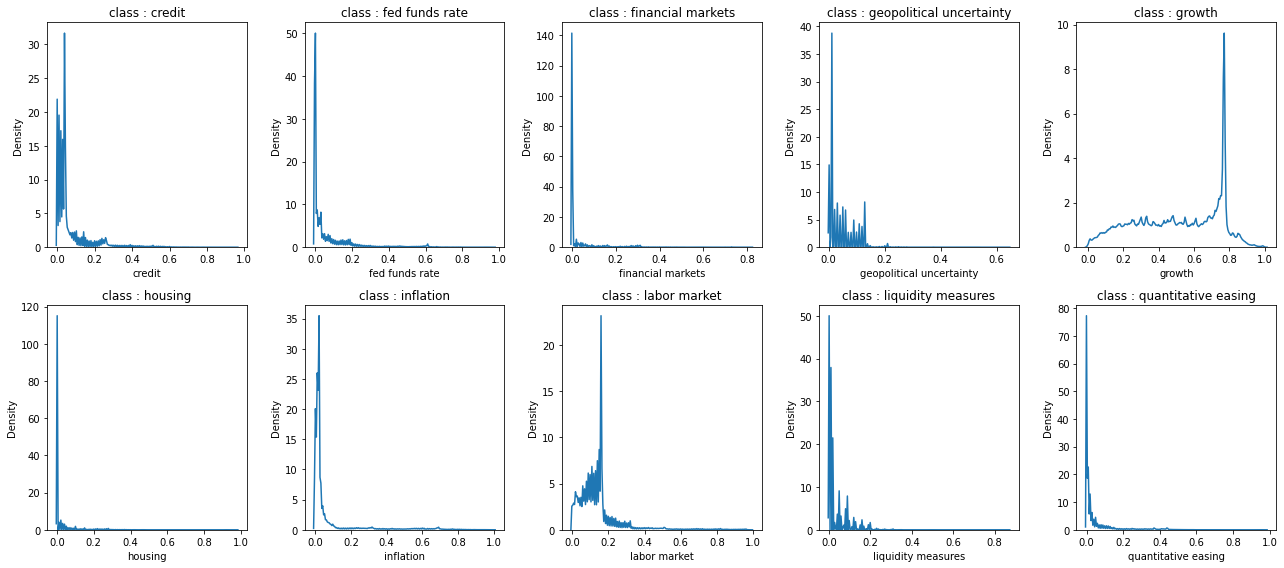

In [44]:
fig, ax = plt.subplots(2,5,figsize = (18,8))
index = 0
for var, subplot in zip(sample_prediction, ax.ravel()):
  if (index >= 10):
    break
  ax = sns.kdeplot(sample_prediction[var], bw_adjust=.25, ax=subplot)
  ax.set_title("class : {}".format(var))
  index += 1
plt.tight_layout()

Plot the feature importance of the random forest model.

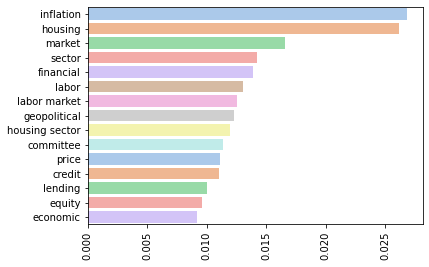

In [49]:
# feature importance
feat_imps = list(zip(tfidf_vec.get_feature_names_out(), rf.feature_importances_))
feats, imps = zip(*sorted(list(filter(lambda x: x[1]!=0, feat_imps)),key=lambda x:x[1], reverse = True))
ax = sns.barplot(list(imps[:15]), list(feats[:15]),palette = "pastel" )
ax.tick_params(axis = 'x', rotation = 90)

Plot the feature importance for each class.

In [45]:
from sklearn.preprocessing import scale
def plot_class_feature_importance(X, Y, feature_importances):
    N, M = X.shape
    X = scale(X,with_mean=False)

    out = {}
    features = list(le.classes_)
    fig, ax = plt.subplots(2,5,figsize = (15,8))
    index = 0
    for var, subplot in zip(features, ax.flatten()):
      if (index >= 13):
        break
      temp = list(zip(tfidf_vec.get_feature_names_out(),np.array((np.multiply(np.mean(X[Y==index,:],axis = 0),(feature_importance.reshape(1,-1))))).flatten()))
      feats, imps = zip(*sorted(list(filter(lambda x: x[1]!=0,temp)),key=lambda x:x[1], reverse = True))
      ax = sns.barplot(list(imps[:15]), list(feats[:15]),palette = "pastel",ax = subplot)
      ax.tick_params(axis = 'x', rotation = 90)
      ax.set_title("class : {}".format(var))
      index += 1
    plt.tight_layout()
    return 

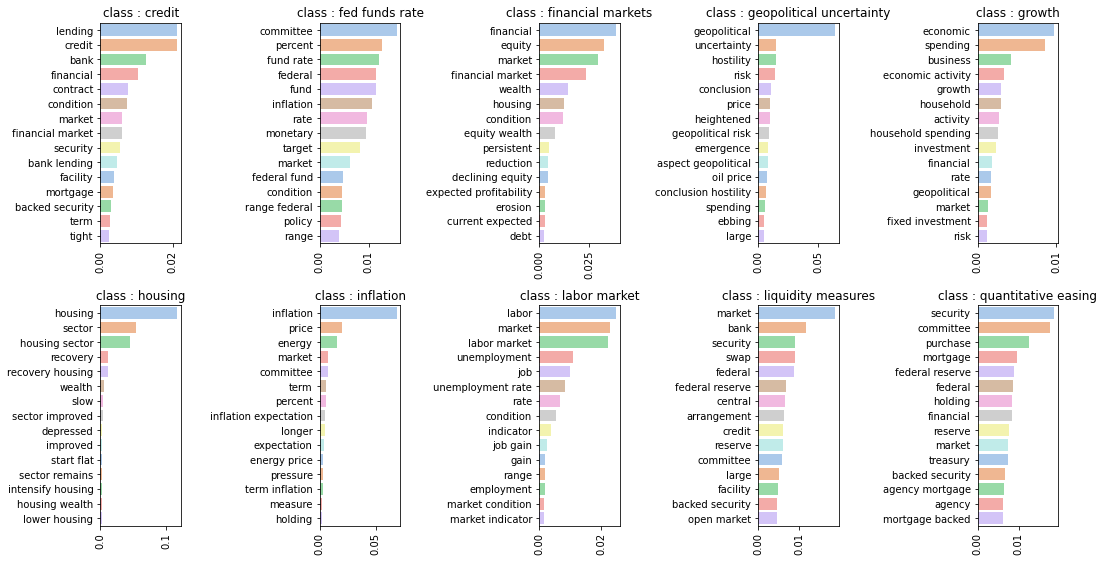

In [46]:
y_target = np.array(list(y_train[0]))
feature_importance = rf.feature_importances_
plot_class_feature_importance(tfidf_X_train,y_target,feature_importance)

## Second Path for "growth"

1. Benchmark
When a sentence is assigned to "growth", keep this label at a 0.5 probability

In [47]:
import random

In [48]:
def get_predicted_topics_random_half_growth(prediction_result,thresh):
  result = []
  for pred in prediction_result:
    label = []
    sum = np.sum(pred)
    for j in range(len(pred)):
      if pred[j]>sum*thresh:
        if le.classes_[j]=="growth" and random.uniform(0,1)>0.5:
          continue
        else:
          label.append(le.classes_[j])
    result.append("/".join(label))
  return result

In [50]:

X_test["predicted_topics_.5_growth"] = get_predicted_topics_random_half_growth(rfPredictions_sample_test,0.25)

In [51]:
result_label_cnt(X_test["predicted_topics_.5_growth"])

credit:21567
fed funds rate:26469
financial markets:17754
geopolitical uncertainty:240
growth:136978
housing:5983
inflation:32518
labor market:33388
liquidity measures:1029
quantitative easing:23624
Non topic:97379


2. Set the threshhold for growth to be higher than other topics

In [52]:
le.classes_

array(['credit', 'fed funds rate', 'financial markets',
       'geopolitical uncertainty', 'growth', 'housing', 'inflation',
       'labor market', 'liquidity measures', 'quantitative easing'],
      dtype=object)

In [53]:
def get_predicted_topics_higher_thresh_growth(prediction_result,thresh,thresh2):
  result = []
  for pred in prediction_result:
    label = []
    sum = np.sum(pred)
    for j in range(len(pred)):
      if pred[j]>sum*thresh:
        if le.classes_[j]=="growth" and pred[j]<thresh2:
          continue
        else:
          label.append(le.classes_[j])
    result.append("/".join(label))
  return result

In [54]:
X_test["predicted_topics_higher_thresh_growth_0.5"] = get_predicted_topics_higher_thresh_growth(rfPredictions_sample_test,0.25,0.5)
result_label_cnt(X_test["predicted_topics_higher_thresh_growth_0.5"])

credit:21567
fed funds rate:26469
financial markets:17754
geopolitical uncertainty:240
growth:183189
housing:5983
inflation:32518
labor market:33388
liquidity measures:1029
quantitative easing:23624
Non topic:27200


In [55]:
X_test["predicted_topics_higher_thresh_growth_0.55"] = get_predicted_topics_higher_thresh_growth(rfPredictions_sample_test,0.25,0.55)
result_label_cnt(X_test["predicted_topics_higher_thresh_growth_0.55"])

credit:21567
fed funds rate:26469
financial markets:17754
geopolitical uncertainty:240
growth:165460
housing:5983
inflation:32518
labor market:33388
liquidity measures:1029
quantitative easing:23624
Non topic:36131


In [56]:
X_test["predicted_topics_higher_thresh_growth_0.6"] = get_predicted_topics_higher_thresh_growth(rfPredictions_sample_test,0.25,0.6)
result_label_cnt(X_test["predicted_topics_higher_thresh_growth_0.6"])

credit:21567
fed funds rate:26469
financial markets:17754
geopolitical uncertainty:240
growth:147224
housing:5983
inflation:32518
labor market:33388
liquidity measures:1029
quantitative easing:23624
Non topic:47728


3. Train a second path model to figure out if the sentence truly belongs to "growth"

**Logistical regression classifier**

In [57]:
## add an new tag to the training data
df_train_is_growth = df_train.copy()
df_train_is_growth["is_growth"] = [0+int("growth" in row.copy()["topic"].replace("global growth", "global")) for index, row in df_train.iterrows()]

In [58]:
# Split training data
X_train_is_growth, X_val_is_growth, y_train_is_growth, y_val_is_growth = train_test_split(df_train_is_growth['text'], df_train_is_growth['is_growth'], stratify = df_train_is_growth['is_growth'], test_size=0.25, random_state=42)

In [59]:
# tifidf fit
min_n = 1
max_n = 2
max_df = 0.8
k = None
tfidf_vec_is_growth = TfidfVectorizer(ngram_range=(min_n,max_n),sublinear_tf=True,max_df=max_df,max_features=k,stop_words=stopwords_list)
tfidf_vec_is_growth.fit(X_train_is_growth)
tfidf_X_train_is_growth = tfidf_vec_is_growth.transform(X_train_is_growth)
tfidf_X_val_is_growth = tfidf_vec_is_growth.transform(X_val_is_growth)

In [60]:
# fit logistic classifier
from sklearn.linear_model import LogisticRegression
logi_clf = LogisticRegression(random_state=0).fit(tfidf_X_train_is_growth, y_train_is_growth)

In [61]:
print("Accuracy score:" + str(logi_clf.score(tfidf_X_val_is_growth,y_val_is_growth)))

Accuracy score:0.9489795918367347


In [62]:
for i in [0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7]:
  y_predicted = [ y[1]>=i for y in logi_clf.predict_proba(tfidf_X_val_is_growth)]
  acc = accuracy_score(y_val_is_growth,y_predicted)
  prec = precision_score(y_val_is_growth,y_predicted)
  recall = recall_score(y_val_is_growth,y_predicted)
  print("Threshhold: {}:\n Accuracy: {}, precision: {}, Recall: {}".format(i,acc, prec, recall))

Threshhold: 0.3:
 Accuracy: 0.9591836734693877, precision: 0.875, Recall: 1.0
Threshhold: 0.35:
 Accuracy: 0.9693877551020408, precision: 0.9032258064516129, Recall: 1.0
Threshhold: 0.4:
 Accuracy: 0.9591836734693877, precision: 0.9615384615384616, Recall: 0.8928571428571429
Threshhold: 0.45:
 Accuracy: 0.9693877551020408, precision: 1.0, Recall: 0.8928571428571429
Threshhold: 0.5:
 Accuracy: 0.9489795918367347, precision: 1.0, Recall: 0.8214285714285714
Threshhold: 0.55:
 Accuracy: 0.9183673469387755, precision: 1.0, Recall: 0.7142857142857143
Threshhold: 0.6:
 Accuracy: 0.8775510204081632, precision: 1.0, Recall: 0.5714285714285714
Threshhold: 0.65:
 Accuracy: 0.826530612244898, precision: 1.0, Recall: 0.39285714285714285
Threshhold: 0.7:
 Accuracy: 0.7959183673469388, precision: 1.0, Recall: 0.2857142857142857


In [63]:
# tfidf sample test data
tfidf_X_test_is_growth = tfidf_vec_is_growth.transform(X_test['text'])

In [64]:
# prediction result for if the sentence below to "growth"
predict_is_growth = logi_clf.predict(tfidf_X_test_is_growth)

In [ ]:
predict_is_growth

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
predict_is_growth_proba = logi_clf.predict_proba(tfidf_X_test_is_growth)

In [ ]:
predict_is_growth_proba

array([[0.68068527, 0.31931473],
       [0.69957326, 0.30042674],
       [0.70425994, 0.29574006],
       ...,
       [0.71668934, 0.28331066],
       [0.73640818, 0.26359182],
       [0.71668934, 0.28331066]])

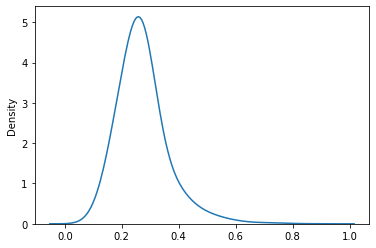

In [ ]:
x = [r[1] for r in predict_is_growth_proba]
sns.kdeplot(np.array(x), bw=0.5)

**Store the trained model**

In [65]:
with open(data_file+'logi_clf.pickle', 'wb') as handle:
    pickle.dump(logi_clf, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(data_file+'rf.pickle', 'wb') as handle:
    pickle.dump(rf, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(data_file+'tfidf_vec.pickle', 'wb') as handle:
    pickle.dump(tfidf_vec, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(data_file+'tfidf_vec_is_growth.pickle', 'wb') as handle:
  pickle.dump(tfidf_vec_is_growth, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [66]:
def get_predicted_topics_is_growth(prediction_topic,predict_is_growth_proba,thresh,growth_threshold):
  result = []
  for i  in range(len(prediction_topic)):
    pred = prediction_topic[i]
    is_growth = predict_is_growth_proba[i]
    label = []
    sum = np.sum(pred)
    for j in range(len(pred)):
      if pred[j]>sum*thresh:
        if le.classes_[j]=="growth" and is_growth[1]<growth_threshold:
          continue
        else:
          label.append(le.classes_[j])
    result.append("/".join(label))
  return result

In [ ]:
X_test["predicted_topics_is_growth_0.5"] = get_predicted_topics_is_growth(rfPredictions_sample_test, predict_is_growth_proba, 0.3, 0.5)
result_label_cnt(X_test["predicted_topics_is_growth_0.5"])

credit:11772
fed funds rate:23888
financial markets:5608
geopolitical uncertainty:182
growth:8166
housing:3653
inflation:29534
labor market:20057
liquidity measures:1185
quantitative easing:7734
Non topic:234273


In [ ]:
X_test["predicted_topics_is_growth_0.6"] = get_predicted_topics_is_growth(rfPredictions_sample_test,predict_is_growth_proba,0.3,0.6)
result_label_cnt(X_test["predicted_topics_is_growth_0.6"])

credit:11772
fed funds rate:23888
financial markets:5608
geopolitical uncertainty:182
growth:2261
housing:3653
inflation:29534
labor market:20057
liquidity measures:1185
quantitative easing:7734
Non topic:239871


In [ ]:
X_test["predicted_topics_is_growth_0.45"] = get_predicted_topics_is_growth(rfPredictions_sample_test,predict_is_growth_proba,0.3,0.45)
result_label_cnt(X_test["predicted_topics_is_growth_0.45"])

credit:11772
fed funds rate:23888
financial markets:5608
geopolitical uncertainty:182
growth:14085
housing:3653
inflation:29534
labor market:20057
liquidity measures:1185
quantitative easing:7734
Non topic:228811


In [ ]:
X_test

,sentence,sentence_order,extracted_date,text_type,aws_file_location,institution,uncleaned_text,text,word_count,predicted_topics,predicted_topics_.5_growth,predicted_topics_higher_thresh_growth_0.5,predicted_topics_higher_thresh_growth_0.55,predicted_topics_higher_thresh_growth_0.6,predicted_topics_is_growth_0.5,predicted_topics_is_growth_0.6,predicted_topics_is_growth_0.45
0,b'Governor Lael Brainard\n\nAt the Council on ...,0,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,Governor Lael Brainard At the Council on For...,governor lael brainard at the council on forei...,12,growth,growth,growth,growth,growth,,,
1,b'Governor Lael Brainard\n\nAt the Council on ...,0,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,The Economic Outlook and Implications for Mone...,the economic outlook and implication for monet...,25,fed funds rate,fed funds rate,fed funds rate,fed funds rate,fed funds rate,fed funds rate,fed funds rate,fed funds rate
2,"On the other hand, there are tentative signs o...",1,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,"On the other hand, there are tentative signs o...","on the other hand, there are tentative sign of...",17,labor market,labor market,labor market,labor market,labor market,labor market,labor market,labor market
3,"On the other hand, there are tentative signs o...",1,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,We cannot take the resilience of our recovery...,we cannot take the resilience of our recovery ...,10,growth,,growth,growth,growth,,,
4,"On the other hand, there are tentative signs o...",1,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,Recent Developments As we consider the approp...,recent development a we consider the appropria...,33,growth,growth,growth,growth,growth,,,growth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363917,The Committee's assessments will take into acc...,10,20201105,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,Mary C. Daly,mary c daly,3,growth,,growth,growth,growth,,,
363920,The Committee's assessments will take into acc...,10,20201105,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,Loretta J. Mester,loretta j mester,3,growth,,growth,growth,growth,,,
363921,The Committee's assessments will take into acc...,10,20201105,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,and Randal K. Quarles.,and randal k quarles,4,growth,growth,growth,growth,growth,,,
363922,Ms. Daly voted as an alternate member at this ...,11,20201105,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,Ms. Daly voted as an alternate member at this ...,m daly voted a an alternate member at this mee...,10,growth,growth,growth,growth,growth,,,


**All predicting method**

In [ ]:
for i in range(10,len(X_test.columns)):
  y = X_test.columns[i]
  tempo = X_test[X_test[y] == "growth"].sample(20, axis = 0)
  tempo.to_csv(data_file+'growth_check/'+str(i)+'.csv')

In [ ]:
i=10
y = X_test.columns[i]
tempo = X_test[X_test[y] == "growth"].sample(20, axis = 0)
tempo.to_csv(data_file+'growth_check/'+str(i)+'.csv')

In [ ]:
sampled_result = X_test[['sentence','sentence_order','extracted_date','text_type','aws_file_location','institution','uncleaned_text','text','word_count','predicted_topics'\
                                 ,'predicted_topics_.5_growth','predicted_topics_higher_thresh_growth_0.6','predicted_topics_is_growth_0.45']]
sampled_result = sampled_result.rename(columns={"predicted_topics_higher_thresh_growth_0.6": "predicted_topics_higher_thresh_growth", "predicted_topics_is_growth_0.45": "predicted_topics_is_growth"})

In [ ]:
sampled_result

,sentence,sentence_order,extracted_date,text_type,aws_file_location,institution,uncleaned_text,text,word_count,predicted_topics,predicted_topics_.5_growth,predicted_topics_higher_thresh_growth,predicted_topics_is_growth
0,b'Governor Lael Brainard\n\nAt the Council on ...,0,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,Governor Lael Brainard At the Council on For...,governor lael brainard at the council on forei...,12,growth,growth,growth,
1,b'Governor Lael Brainard\n\nAt the Council on ...,0,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,The Economic Outlook and Implications for Mone...,the economic outlook and implication for monet...,25,fed funds rate,fed funds rate,fed funds rate,fed funds rate
2,"On the other hand, there are tentative signs o...",1,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,"On the other hand, there are tentative signs o...","on the other hand, there are tentative sign of...",17,labor market,labor market,labor market,labor market
3,"On the other hand, there are tentative signs o...",1,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,We cannot take the resilience of our recovery...,we cannot take the resilience of our recovery ...,10,growth,,growth,
4,"On the other hand, there are tentative signs o...",1,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,Recent Developments As we consider the approp...,recent development a we consider the appropria...,33,growth,growth,growth,growth
...,...,...,...,...,...,...,...,...,...,...,...,...,...
363917,The Committee's assessments will take into acc...,10,20201105,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,Mary C. Daly,mary c daly,3,growth,,growth,
363920,The Committee's assessments will take into acc...,10,20201105,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,Loretta J. Mester,loretta j mester,3,growth,,growth,
363921,The Committee's assessments will take into acc...,10,20201105,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,and Randal K. Quarles.,and randal k quarles,4,growth,growth,growth,
363922,Ms. Daly voted as an alternate member at this ...,11,20201105,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,Ms. Daly voted as an alternate member at this ...,m daly voted a an alternate member at this mee...,10,growth,growth,growth,


In [ ]:
sampled_result.columns

Index(['sentence', 'sentence_order', 'extracted_date', 'text_type',
       'aws_file_location', 'institution', 'uncleaned_text', 'text',
       'word_count', 'predicted_topics', 'predicted_topics_.5_growth',
       'predicted_topics_higher_thresh_growth', 'predicted_topics_is_growth'],
      dtype='object')

In [ ]:
sampled_result_multilabel = sampled_result[sampled_result['predicted_topics_is_growth'].str.contains("/")]

In [ ]:
sampled_result.to_csv(data_file+'sampled_result.csv')

In [ ]:
sampled_result

,sentence,sentence_order,extracted_date,text_type,aws_file_location,institution,uncleaned_text,text,word_count,predicted_topics,predicted_topics_.5_growth,predicted_topics_higher_thresh_growth,predicted_topics_is_growth
0,b'Governor Lael Brainard\n\nAt the Council on ...,0,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,Governor Lael Brainard At the Council on For...,governor lael brainard at the council on forei...,12,growth,growth,growth,
1,b'Governor Lael Brainard\n\nAt the Council on ...,0,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,The Economic Outlook and Implications for Mone...,the economic outlook and implication for monet...,25,fed funds rate,fed funds rate,fed funds rate,fed funds rate
2,"On the other hand, there are tentative signs o...",1,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,"On the other hand, there are tentative signs o...","on the other hand, there are tentative sign of...",17,labor market,labor market,labor market,labor market
3,"On the other hand, there are tentative signs o...",1,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,We cannot take the resilience of our recovery...,we cannot take the resilience of our recovery ...,10,growth,,growth,
4,"On the other hand, there are tentative signs o...",1,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,Recent Developments As we consider the approp...,recent development a we consider the appropria...,33,growth,growth,growth,growth
...,...,...,...,...,...,...,...,...,...,...,...,...,...
363917,The Committee's assessments will take into acc...,10,20201105,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,Mary C. Daly,mary c daly,3,growth,,growth,
363920,The Committee's assessments will take into acc...,10,20201105,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,Loretta J. Mester,loretta j mester,3,growth,,growth,
363921,The Committee's assessments will take into acc...,10,20201105,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,and Randal K. Quarles.,and randal k quarles,4,growth,growth,growth,
363922,Ms. Daly voted as an alternate member at this ...,11,20201105,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,Ms. Daly voted as an alternate member at this ...,m daly voted a an alternate member at this mee...,10,growth,growth,growth,


In [ ]:
sampled_result_multilabel.to_csv(data_file+'sampled_result_multilabel.csv')

In [ ]:
sampled_result_multilabel.shape

(5514, 13)

In [ ]:
sampled_result_multilabel

,sentence,sentence_order,extracted_date,text_type,aws_file_location,institution,uncleaned_text,text,word_count,predicted_topics,predicted_topics_.5_growth,predicted_topics_higher_thresh_growth,predicted_topics_is_growth
36,The rise in the dollar and decline in foreign ...,25,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,The rise in the dollar and decline in foreign ...,the rise in the dollar and decline in foreign ...,36,growth/inflation,growth/inflation,inflation,growth/inflation
64,While signs of weakness in business investment...,44,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,While signs of weakness in business investment...,while sign of weakness in business investment ...,28,growth/labor market,labor market,labor market,growth/labor market
75,"In particular, it appears likely that the medi...",53,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,"In particular, it appears likely that the medi...","in particular, it appears likely that the medi...",32,fed funds rate/inflation,fed funds rate/inflation,fed funds rate/inflation,fed funds rate/inflation
115,"""The Role of Entrepreneurship in U.S. Job Crea...",82,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,"""The Role of Entrepreneurship in U.S. Job Crea...",the role of entrepreneurship in u job creatio...,16,growth/labor market,growth/labor market,labor market,growth/labor market
298,With housing activity well below pre-recession...,9,20160307,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,With housing activity well below pre-recession...,with housing activity well below pre recession...,20,growth/housing,housing,housing,growth/housing
...,...,...,...,...,...,...,...,...,...,...,...,...,...
363885,The Committee's assessments will take into acc...,10,20200916,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,The Committee's assessments will take into acc...,the committee assessment will take into accou...,30,inflation/labor market,inflation/labor market,inflation/labor market,inflation/labor market
363895,The Committee's assessments will take into acc...,10,20200916,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,"and Neel Kashkari, who prefers that the Commit...","and neel kashkari, who prefers that the commit...",29,fed funds rate/inflation,fed funds rate/inflation,fed funds rate/inflation,fed funds rate/inflation
363903,The ongoing public health crisis will continue...,4,20201105,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,The ongoing public health crisis will continue...,the ongoing public health crisis will continue...,31,growth/inflation,inflation,inflation,growth/inflation
363904,The ongoing public health crisis will continue...,4,20201105,statement,/home/lwu/reports/sentiment/txt/fomcstat/fomcs...,fomc,The Committee seeks to achieve maximum employm...,the committee seek to achieve maximum employme...,18,fed funds rate/inflation,fed funds rate/inflation,fed funds rate/inflation,fed funds rate/inflation


# BERT

## Basic BERT

## finBERT

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 8.4 MB/s 
     |████████████████████████████████| 596 kB 56.3 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 6.6 MB 37.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoModel

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

# model 
# produce embedding layer
model = AutoModel.from_pretrained("ProsusAI/finbert")

# produce setiment classification
# model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
model.eval()

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
def get_feature(data_sets, model):
    X = []
    with torch.no_grad():
        for i in range(len(data_sets)):
            inputs = tokenizer(data_sets[i], padding=True,
                               return_tensors="pt")
            outputs = model(**inputs)
            X.append(np.array(torch.sum(outputs.last_hidden_state[0],0)))
    return X

In [ ]:
X_train

sentence_id
126                       may generate economic weakness
368    balance sheet normalization program initiated ...
323    arrangement bank england ecb swiss national ba...
222            indicates labor market condition improved
106    nd slowing export growth likely weigh economic...
                             ...                        
153                      sharp decline economic activity
338    policy keeping committee holding longer term s...
386                   march  loan backed type collateral
199           may generate heightened inflation pressure
311     first firming reserve market condition committee
Name: text, Length: 294, dtype: object

In [ ]:
finBert_data_train = get_feature(np.array(X_train),model)
finBert_data_val = get_feature(np.array(X_val),model)


In [ ]:
finBert_data_train = np.array(finBert_data_train)

In [ ]:
# Random Forest
rf_bert = RandomForestClassifier(class_weight='balanced')
rf_bert.fit(finBert_data_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [ ]:
rfPrediction_finbert = rf_bert.predict_proba(finBert_data_val)

In [ ]:
for i in np.arange(0.1,0.5,0.05):
  rfPredictions_val = get_predicted_topics(rfPrediction_finbert,i)
  rfPredictions_val_df = pd.DataFrame(rfPredictions_val, index=X_val.index)
  rfPredictions_val_df = rfPredictions_val_df[~rfPredictions_val_df.index.duplicated(keep='first')]
  acc, prec, recall = cust_acc(rfPredictions_val_df[0], df_val['topic'])
  print("Threshhold: {}:\n Accuracy: {}, precision: {}, Recall: {}".format(i,acc, prec, recall))

Threshhold: 0.1:
 Accuracy: 0.23469387755102042, precision: 0.49659863945578253, Recall: 0.9285714285714286
Threshhold: 0.15000000000000002:
 Accuracy: 0.3877551020408163, precision: 0.5952380952380952, Recall: 0.8571428571428571
Threshhold: 0.20000000000000004:
 Accuracy: 0.4897959183673469, precision: 0.6462585034013606, Recall: 0.8061224489795918
Threshhold: 0.25000000000000006:
 Accuracy: 0.6020408163265306, precision: 0.6785714285714286, Recall: 0.7551020408163265
Threshhold: 0.30000000000000004:
 Accuracy: 0.6428571428571429, precision: 0.6887755102040817, Recall: 0.7346938775510204
Threshhold: 0.3500000000000001:
 Accuracy: 0.673469387755102, precision: 0.6836734693877551, Recall: 0.6938775510204082
Threshhold: 0.40000000000000013:
 Accuracy: 0.5918367346938775, precision: 0.5969387755102041, Recall: 0.6020408163265306
Threshhold: 0.45000000000000007:
 Accuracy: 0.5102040816326531, precision: 0.5102040816326531, Recall: 0.5102040816326531


In [ ]:
#logistic regression

In [ ]:
LogReg_pipeline = LogisticRegression(random_state=0).fit(finBert_data_train, y_train)
prediction_bert = LogReg_pipeline.predict(finBert_data_val) 
accuracy_score(y_val, prediction_bert)

0.8061224489795918

It seems that using finBERT as embedding didn't bring much improve.